In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as MAE

import pandapower as pp
import pandapower.networks as pn

%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6

In [2]:
## Load power flow data
branch_true_corr = pd.read_csv('edge_true_corr.csv', index_col=0, header=0).to_numpy()
branch_true_corr = np.abs(branch_true_corr)
branch_pred_corr = pd.read_csv('edge_pred_corr.csv', index_col=0, header=0).to_numpy()
branch_pred_corr = np.abs(branch_pred_corr)

## Load loading percent data
lp_true_corr = pd.read_csv('lp_true_corr.csv', index_col=0, header=0).to_numpy()

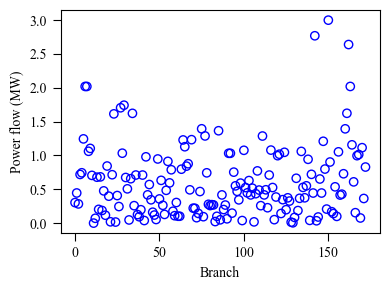

In [3]:
# One example of loading percent
plt.figure(figsize=(4, 3))
plt.scatter(np.arange(173),
            lp_true_corr[:, 100], 
            marker='o',
            facecolors='none',
            edgecolors='blue',
            label='Branch power flow')
plt.xlabel('Branch')
plt.ylabel('Power flow (MW)')

plt.tight_layout()
plt.show()
plt.close('all')

In [4]:
# Select critical branches
branches = np.zeros(lp_true_corr.shape[0])
for i in range(branches.shape[0]):
    for j in range(lp_true_corr.shape[1]):
        if np.isin(i, np.argsort(lp_true_corr[:, j])[-20:]):
            branches[i] += 1

cri_indices = np.sort(np.argsort(branches)[-20:])

In [5]:
cri_indices

array([  6,   7,  23,  27,  29,  34,  49,  64,  75,  85, 109, 111, 116,
       117, 138, 142, 150, 161, 162, 163])

In [6]:
## Calculate prediction loading percent
max_pf_corr = branch_true_corr/lp_true_corr*100
lp_pred_corr = branch_pred_corr/max_pf_corr*100

In [7]:
## Set load percent threshold
lp_threshold = 2.

In [8]:
## Select loading percent of critical branches
lp_cri_true_corr = lp_true_corr[cri_indices, :]
lp_cri_pred_corr = lp_pred_corr[cri_indices, :]

In [9]:
## Get the probability of heavy loading
heavy_load_prob_true = np.zeros(len(cri_indices))
heavy_load_prob_pred = np.zeros(len(cri_indices))
for i in range(len(cri_indices)):
    heavy_load_prob_true[i] = (lp_cri_true_corr[i, :]>=lp_threshold).sum()/lp_cri_true_corr.shape[1]
    heavy_load_prob_pred[i] = (lp_cri_pred_corr[i, :]>=lp_threshold).sum()/lp_cri_pred_corr.shape[1]

In [10]:
## MC samples
# The matrix to store conditional probability
con_prob_mat_true = np.zeros((len(cri_indices), len(cri_indices)))
# Indices for con_prob_mat
p = -1

for i in cri_indices:
    p += 1
    # Select MC samples that i-th branch is heavily loaded
    col_indices = lp_true_corr[i]>=lp_threshold
    # Avoid empty array
    if col_indices.sum() <= 0:
        continue
    # Select corresponding columns
    temp1 = lp_true_corr[:, col_indices]
    # Calculate conditional probability
    q = 0
    for j in cri_indices:
        con_prob = (temp1[j]>=lp_threshold).sum()/temp1.shape[1]
        con_prob_mat_true[p, q] = con_prob
        q += 1

## Predictions
# The matrix to store conditional probability
con_prob_mat_pred = np.zeros((len(cri_indices), len(cri_indices)))
# Indices for con_prob_mat
p = -1

for i in cri_indices:
    p += 1
    # Select MC samples that i-th branch is heavily loaded
    col_indices = lp_pred_corr[i]>=lp_threshold
    # Avoid empty array
    if col_indices.sum() <= 0:
        continue
    # Select corresponding columns
    temp1 = lp_pred_corr[:, col_indices]
    # Calculate conditional probability
    q = 0
    for j in cri_indices:
        con_prob = (temp1[j]>=lp_threshold).sum()/temp1.shape[1]
        con_prob_mat_pred[p, q] = con_prob
        q += 1

In [11]:
# # Risk is defined with respect to monetary cost
# Define unit cost = $100
unit_cost = np.ones(len(cri_indices))*100
# Calculate overall cost (Note that if unit cost is not the same value, the risk should be calculated separately)
risk_true_corr = con_prob_mat_true@unit_cost
risk_pred_corr = con_prob_mat_pred@unit_cost

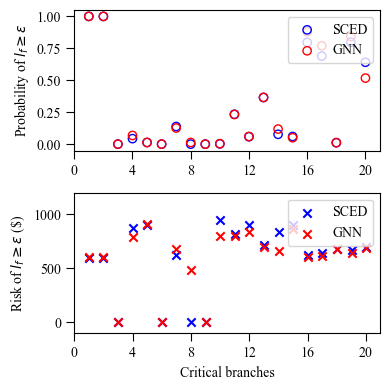

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.scatter(np.arange(1, len(cri_indices)+1), 
            heavy_load_prob_true,
            marker='o',
            facecolors='none',
            edgecolors='blue',
            label='SCED')
ax1.scatter(np.arange(1, len(cri_indices)+1), 
            heavy_load_prob_pred,
            marker='o',
            facecolors='none',
            edgecolors='red',
            label='GNN')
ax1.set_xlim((0, 21))
ax1.set_xticks(np.linspace(0, 20, 6))
ax1.set_xticklabels(['0', '4', '8', '12', '16', '20'])
ax1.set_ylabel('Probability of $l_f \geq \epsilon$')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(212)
ax2.scatter(np.arange(1, len(cri_indices)+1), 
            risk_true_corr,
            marker='x',
            facecolors='blue',
            label='SCED')
ax2.scatter(np.arange(1, len(cri_indices)+1), 
            risk_pred_corr,
            marker='x',
            facecolors='red',
            label='GNN')
ax2.set_xticks(np.linspace(0, 20, 6))
ax2.set_xticklabels(['0', '4', '8', '12', '16', '20'])
ax2.set_ylabel('Probability of $l_f \geq \epsilon$')
ax2.set_xlabel('Critical branches')
ax2.set_ylim(-100, 1200)
ax2.set_ylabel('Risk of $l_f \geq \epsilon$ (\$)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
plt.close('all')

In [13]:
pf_risk = pd.concat([pd.Series(heavy_load_prob_true, name='pf_true'),
                     pd.Series(heavy_load_prob_pred, name='pf_pred'),
                     pd.Series(risk_true_corr, name='risk_true'),
                     pd.Series(risk_pred_corr, name='risk_pred')],
                     axis=1)
pf_risk.to_csv('./reliability_risk.csv')

#### Plot conditional probability

In [73]:
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (12, 2)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
from roman import toRoman

In [155]:
## MC samples
# The matrix to store conditional probability
con_prob_mat_true = np.zeros((173, 173))

# for i in cri_indices:
for i in range(173):
    # Select MC samples that i-th branch is heavily loaded
    col_indices = lp_true_corr[i]>=lp_threshold
    # Avoid empty array
    if col_indices.sum() <= 0:
        continue
    # Select uniformesponding columns
    temp1 = lp_true_corr[:, col_indices]
    # Calculate conditional probability
    # for j in cri_indices:
    #     con_prob = (temp1[j]>=lp_threshold).sum()/temp1.shape[1]
    #     con_prob_mat_true[p, q] = con_prob
    #     q += 1
    for j in range(173):
        con_prob = (temp1[j]>=lp_threshold).sum()/temp1.shape[1]
        con_prob_mat_true[i, j] = con_prob

con_prob_mat_true = con_prob_mat_true[cri_indices]

In [156]:
## Predictions
# The matrix to store conditional probability
con_prob_mat_pred = np.zeros((173, 173))

# for i in cri_indices:
for i in range(173):
    # Select MC samples that i-th branch is heavily loaded
    col_indices = lp_pred_corr[i]>=lp_threshold
    # Avoid empty array
    if col_indices.sum() <= 0:
        continue
    # Select uniformesponding columns
    temp1 = lp_pred_corr[:, col_indices]
    # Calculate conditional probability
    # for j in cri_indices:
    #     con_prob = (temp1[j]>=lp_threshold).sum()/temp1.shape[1]
    #     con_prob_mat_true[p, q] = con_prob
    #     q += 1
    for j in range(173):
        con_prob = (temp1[j]>=lp_threshold).sum()/temp1.shape[1]
        con_prob_mat_pred[i, j] = con_prob

con_prob_mat_pred = con_prob_mat_pred[cri_indices]

In [157]:
# Create index using Roman numerals
row_index = [toRoman(i).lower() for i in range(1, 21)]

con_prob_mat_true = pd.DataFrame(con_prob_mat_true,
                                 index=row_index)

con_prob_mat_pred = pd.DataFrame(con_prob_mat_pred,
                                 index=row_index)

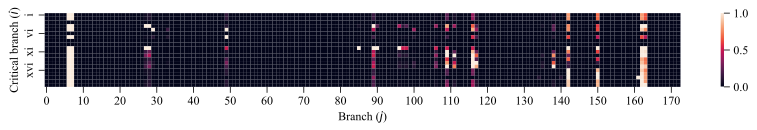

In [158]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(con_prob_mat_true, 
            ax=ax,
            xticklabels=10,
            yticklabels=5)
ax.set_xlabel('Branch ($j$)')
ax.set_ylabel('Critical branch ($i$)')

# plt.tight_layout()
plt.tight_layout()
plt.show()
plt.close('all')

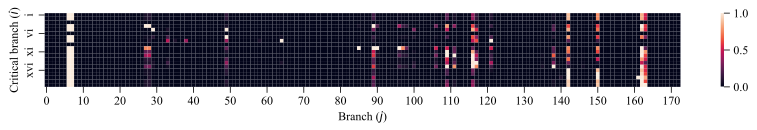

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(con_prob_mat_pred, 
            ax=ax,
            xticklabels=10,
            yticklabels=5)
ax.set_xlabel('Branch ($j$)')
ax.set_ylabel('Critical branch ($i$)')

# plt.tight_layout()
plt.tight_layout()
plt.show()
plt.close('all')